# *SDS_Benchmark*: Preprocess groundtruth datasets


This notebook shows how to download and preprocess groundtruth shoreline data for 4 different sites:
- Narrabeen, Australia [ref](https://www.nature.com/articles/sdata201624)
- Duck, North Carolina, USA [ref](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2014JC010329)
- Truc Vert, France [ref](https://www.nature.com/articles/s41597-020-00750-5#Tab2)
- Torrey Pines, California, USA [ref](https://www.nature.com/articles/s41597-019-0167-6)

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `geopandas`, `netCDF4`, `pytz`, `urllib3`, `bs4` and `wget`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import interpolate
from scipy import stats
import pickle
import warnings
from netCDF4 import Dataset            
from datetime import datetime, timedelta
import pytz

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
matplotlib.use('Qt5Agg')
%matplotlib inline
warnings.filterwarnings("ignore")

# create folder structure for the 4 sites
for site in ['NARRABEEN','DUCK','TRUCVERT','TORREYPINES']:
    data_folder = os.path.join('datasets',site)
    if not os.path.exists(data_folder): os.makedirs(data_folder)
    fp_raw = os.path.join(data_folder,'raw')
    if not os.path.exists(fp_raw): os.makedirs(fp_raw)

## 1. Narrabeen, Australia, WRL dataset

First, you need to download the survey data from the [Narrabeen website](http://narrabeen.wrl.unsw.edu.au/). Go to the website, click `Download data`, then create a new user and select `Narrabeen Profile Data` as shown below:

![image.png](./doc/download_narrabeen.png)

A csv file called `Narrabeen_profiles.csv` will be downloaded, copy it into the `./datasets/NARRABEEN/raw` folder. 

The cell below is used to preprocess the data into time-series of shoreline change at a user-define contour level (0.7 m for Narrabeen, which corresponds to Mean High Water Springs). 

The time-series of shoreline change are saved as `NARRABEEN_groundtruth.pkl` in the `./datasets/NARRABEEN` folder.

In [35]:
sitename = 'NARRABEEN'
data_folder = os.path.join('datasets',sitename)
fp_raw = os.path.join(data_folder,'raw')

Extracting time-series for 5 transects using the 0.7 m contour...
Time-series for the 1 m contour along 5 transects were saved at datasets\NARRABEEN\NARRABEEN_groundtruth.pkl


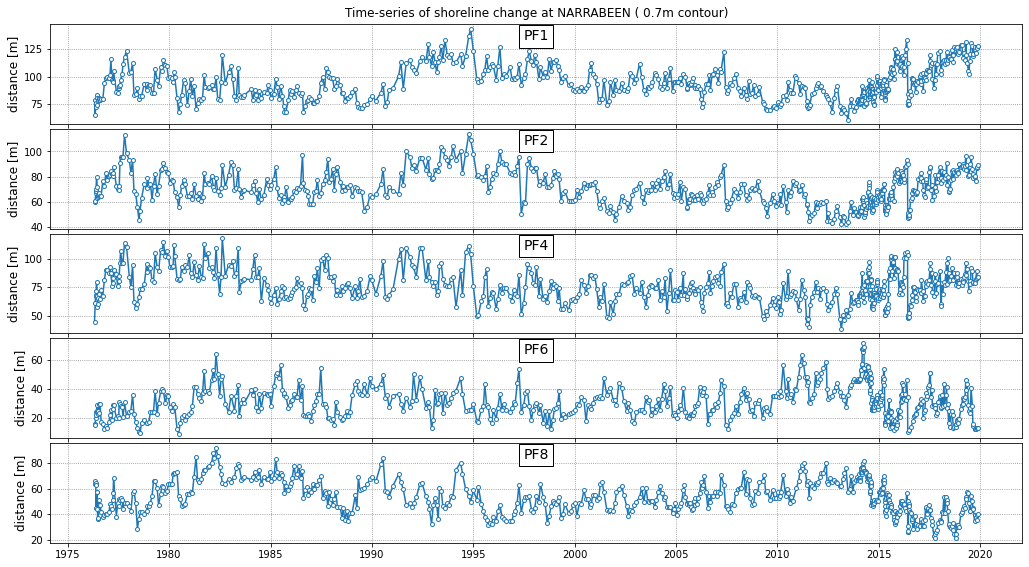

In [36]:
# read the csv file
fp_dataset = os.path.join(fp_raw,'Narrabeen_Profiles.csv')
df = pd.read_csv(fp_dataset)
pf_names = list(np.unique(df['Profile ID']))

# select contour level
contour_level = 0.7

print('Extracting time-series for %d transects using the %.1f m contour...'%(len(pf_names),contour_level))

# initialise topo_profiles structure
topo_profiles = dict([])
for i in range(len(pf_names)): # for each profile
     # read dates
    df_pf = df.loc[df['Profile ID'] == pf_names[i]]
    dates_str = df['Date']
    dates_unique = np.unique(dates_str)
    # loop through dates
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    for date in dates_unique:
        # extract chainage and elevation for that date
        df_date = df_pf.loc[dates_str == date]
        chainages = np.array(df_date['Chainage'])
        elevations = np.array(df_date['Elevation'])
        if len(chainages) < 3: continue
        # sort by chainages
        idx_sorted = np.argsort(chainages)
        chainages = chainages[idx_sorted]
        elevations = elevations[idx_sorted]
        chainages_interp = np.arange(np.min(chainages)-1,np.max(chainages)+1,1)
        elevations_interp = np.interp(chainages_interp,chainages,elevations)
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations_interp, chainages_interp, bounds_error=False)
        chainage_contour_level = f(contour_level)
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        date_utc = pytz.utc.localize(datetime.strptime(date,'%Y-%m-%d'))
        topo_profiles[pf_names[i]]['dates'].append(date_utc)

# save time-series in a pickle file
fp_save = os.path.join(data_folder, '%s_groundtruth.pkl'%sitename)
with open(fp_save, 'wb') as f:
    pickle.dump(topo_profiles, f)
print('Time-series for the %1.f m contour along %d transects were saved at %s'%(contour_level,len(pf_names),fp_save))
      
# plot time-series for each transect
fig = plt.figure(figsize=[15,8], tight_layout=True)
fig.suptitle('Time-series of shoreline change at %s ( %.1fm contour)'%(sitename,contour_level))
gs = gridspec.GridSpec(len(topo_profiles),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(topo_profiles.keys()):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  
fig.savefig(os.path.join(data_folder, '%s_insitu_timeseries.jpg'%sitename), dpi=100);

Now that we have preprocessed the in situ shoreline time-series, `.\datasets\NARRABEEN\NARRABEEN_groundtruth.pkl`, we can use them to evaluate the accuracy of satellite-derived shorelines.

The inputs for this site are provided under `./datasets/NARRABEEN/`:
- Region of Interest (ROI): `NARRABEEN_polygon.geojson` in WGS84 (epsg:4326)
- Reference shoreline: `NARRABEEN_reference_shoreline.geojson` in WGS84 (epsg:4326)
- Transect coordinates: `NARRABEEN_transects.geojson`  in WGS84 (epsg:4326)
- Modelled tide levels: `NARRABEEN_tides.csv` dates in UTC time and tide levels in metres Above Mean Sea Level
- Beach-face slope: use $tan\beta = 0.1$

The cell below shows how to load the input files:

Loaded polygon in epsg:4326
Loaded reference shoreline in epsg:4326
Loaded transects in epsg:4326
Plotted polygon, reference shoreline and transects
Loaded tide time-series
Plotted tide time-series


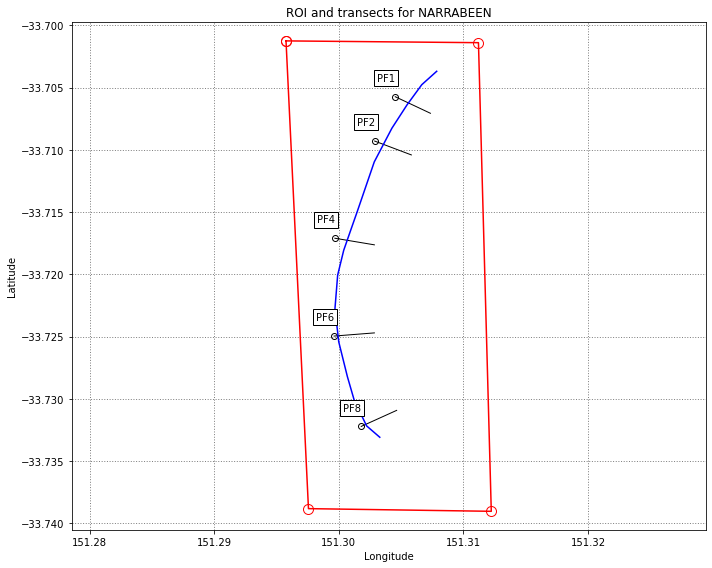

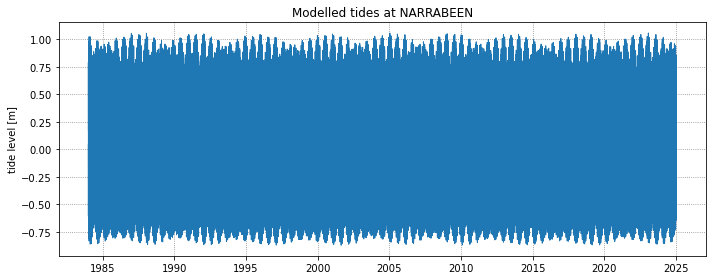

In [37]:
# read polygon ROI
fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
gdf_polygon = gpd.read_file(fn_polygon)
print('Loaded polygon in epsg:%d'%gdf_polygon.crs.to_epsg())
polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
# read reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
# read transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot transects and polygon
fig,ax = plt.subplots(1,1,figsize=(10,8),tight_layout=True)
ax.grid(which='major',ls=':',c='0.5',lw=1)
ax.axis('equal')
ax.set(xlabel='Longitude',ylabel='Latitude',title='ROI and transects for %s'%sitename)
for i,key in enumerate(list(transects.keys())):
    ax.plot(transects[key][0,0],transects[key][0,1], 'ko',mfc='None',ms=6)
    ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    ax.text(transects[key][0,0], transects[key][0,1]+0.0015, key,
            va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
ax.plot(polygon[:,0],polygon[:,1],'r-o',mfc='None',ms=10)
ax.plot(refsl[:,0],refsl[:,1],'b-')
print('Plotted polygon, reference shoreline and transects')
fig.savefig(os.path.join(data_folder, '%s_inputs.jpg'%sitename), dpi=100);

# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])
print('Loaded tide time-series')

# plot tide time-series
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-',lw=1)
ax.set(ylabel='tide level [m]',title='Modelled tides at %s'%sitename)
print('Plotted tide time-series')
fig.savefig(os.path.join(data_folder, '%s_tides.jpg'%sitename), dpi=100);

## 2. Duck, North Carolina, FRF dataset

The Duck survey date is located in an CHL server so it can be downloaded programmatically.

The data is organised in .nc files, one file per survey date.

The cell below downloads all the survey dates from the server and process them into shoreline time-series along transects:
https://chlthredds.erdc.dren.mil/thredds/catalog/frf/geomorphology/elevationTransects/survey/data/catalog.html

![image.png](./doc/download_duck.PNG)

In [2]:
# folder to save the files in
sitename = 'DUCK'
data_folder = os.path.join('datasets',sitename)
fp_raw = os.path.join(data_folder,'raw')

In [62]:
# import extra packages and setup ssl context for http downloads
import ssl
import urllib3
from bs4 import BeautifulSoup
import wget

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

If you don't have `wget` and/or `netCDF4` installed, you can install them on the spot with:
`pip install wget bs4 urllib3`

Get the names of the files that will be downloaded from the catalog.html

In [25]:
# parse catalog to find all the file names
http = urllib3.PoolManager()
url_catalog = 'https://chlthredds.erdc.dren.mil/thredds/catalog/frf/geomorphology/elevationTransects/survey/data/catalog.html'
response = http.request('GET', url_catalog)
soup = BeautifulSoup(response.data)
# split string
soup_str = soup.text
soup_split = soup_str.split('.nc')
print('Found %d files to download'%len(soup_split))

Found 1133 files to download


Download the files with the survey data (takes approx. 15 minutes)

In [38]:
# download all the files
main_http_server = 'https://chlthredds.erdc.dren.mil/thredds/fileServer/frf/geomorphology/elevationTransects/survey/data/'
print('Downloading %d files...'%(len(soup_split)))
for i,text in enumerate(soup_split):
    fn = text[text.find('FRF'):]
    if i == len(soup_split) -1: continue # skip last line
    # check that date is after 1984 to speed things up
    date = fn[-8:]
    if int(date[:4]) < 1984: continue
    url = main_http_server + fn + '.nc'
    if os.path.exists(os.path.join(fp_raw,fn+'.nc')):
        continue
    # download file (try until host responds)
    file = []
    while True:
        try:
            file = wget.download(url, out=fp_raw)
            if len(file) > 0:
                break
        except:
            continue

Now we organise the data by transects. The FRF transects can be visualised on the FRF Data Porttal (https://frfdataportal.erdc.dren.mil/).

![image.png](./doc/transects_duck.PNG)

Here we pre-select the transects that have the most temporal depth in terms of surveys and extract time-series of shoreline change along those transects only.

Note that the elevation data is in NAVD88, so Mean High Water is about 0.4 m based on the local [NOAA tide gauge](https://tidesandcurrents.noaa.gov/datums.html?datum=NAVD88&units=1&epoch=0&id=8651370&name=Duck&state=NC).

The time-series of shoreline change are saved as `DUCK_groundtruth.pkl` in the `./datasets/DUCK` folder.

Extracting time-series for 30 transects using the 0.4 m contour...
Time-series for the 0 m contour along 30 transects were saved at datasets\DUCK\DUCK_groundtruth.pkl


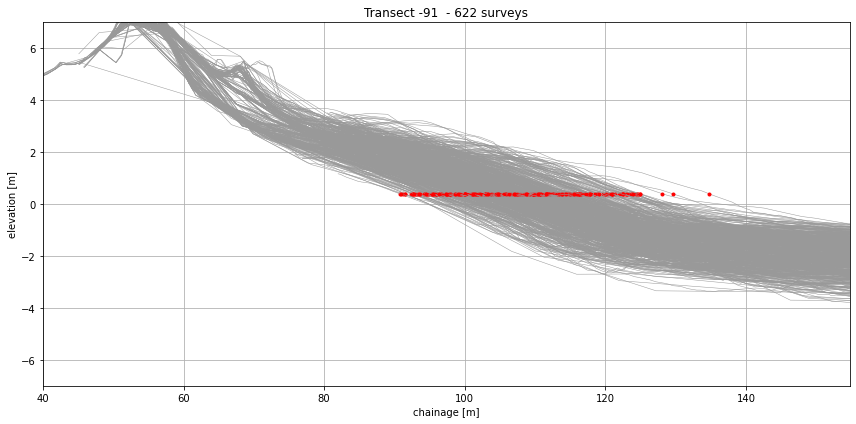

In [20]:
# all surveyed profiles
profiles = [-91,-46, 1,46, 91, 137, 183, 229, 274, 320, 366, 411, 457, 558, 594, 640, 686, 731, 
            777, 823, 869, 914, 960, 1006, 1052, 1097, 1157, 1217, 1277, 1337]
pf_names = [str(_) for _ in profiles]

contour_level = 0.4 # = MHW in Navd88

print('Extracting time-series for %d transects using the %.1f m contour...'%(len(pf_names),contour_level))

# read all files and merge them
survey_data = dict([])
filenames = os.listdir(fp_raw)
filenames = [_ for _ in filenames if not _ == '.nc']
for fn in filenames:
    data = Dataset(os.path.join(fp_raw,fn))
    date_str = fn[-11:].split('.nc')[0]
    if date_str == '19890523': continue     # skip problematic survey
    date = pytz.utc.localize(datetime.strptime(date_str,'%Y%m%d'))
    survey_number = np.array(data.variables['surveyNumber'][:])[0]
    survey_data[str(survey_number)] = dict([])
    survey_data[str(survey_number)]['date'] = date
    survey_data[str(survey_number)]['latitude'] = np.array(data.variables['lat'][:])
    survey_data[str(survey_number)]['longitude'] = np.array(data.variables['lon'][:])
    survey_data[str(survey_number)]['x'] = np.array(data.variables['xFRF'][:])
    survey_data[str(survey_number)]['y'] = np.array(data.variables['yFRF'][:])
    survey_data[str(survey_number)]['elevation'] = np.array(data.variables['elevation'][:])
    survey_data[str(survey_number)]['profile'] = np.array(data.variables['profileNumber'][:])

# format the data by profile and not by date
fp_figs = os.path.join(data_folder,'figs_profiles')
if not os.path.exists(fp_figs): os.makedirs(fp_figs)
topo_profiles = dict([])
n_surveys = np.zeros(len(pf_names))
for i in range(len(pf_names)):
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    fig, ax = plt.subplots(1,1,figsize=(12,6),tight_layout=True)
    ax.grid()
    for n in list(survey_data.keys()):
        survey = survey_data[n]
        idx = np.where(survey['profile'] == profiles[i])[0]
        if len(idx) < 3: 
            continue
        date = survey_data[n]['date']
        chainages = survey['x'][idx]
        elevations = survey['elevation'][idx]
        # sort by chainages
        idx_sorted = np.argsort(chainages)
        chainages = chainages[idx_sorted]
        elevations = elevations[idx_sorted]
        chainages_interp = np.arange(np.min(chainages)-1,np.max(chainages)+1,1)
        elevations_interp = np.interp(chainages_interp,chainages,elevations)
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations_interp, chainages_interp, bounds_error=False)
        chainage_contour_level = float(f(contour_level))
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        topo_profiles[pf_names[i]]['dates'].append(date)        
        ax.plot(chainages,elevations,'-',c='0.6',lw=0.5)
        ax.plot(chainage_contour_level,contour_level,'r.')

    # convert to np.array
    topo_profiles[pf_names[i]]['chainages'] = np.array(topo_profiles[pf_names[i]]['chainages'])
    n_surveys[i] = len(topo_profiles[pf_names[i]]['dates'])
    if len(topo_profiles[pf_names[i]]['dates']) > 0:
        ax.set(title = 'Transect %s  - %d surveys'%(pf_names[i],len(topo_profiles[pf_names[i]]['dates'])),
               xlabel='chainage [m]', ylabel='elevation [m]', ylim=[-7,7],
               xlim=[40,np.nanmax(topo_profiles[pf_names[i]]['chainages'])+20])    
        fig.savefig(os.path.join(fp_figs, 'transect_%s.jpg'%pf_names[i]), dpi=100)
        if i > 0: plt.close(fig)
    else:
        topo_profiles.pop(pf_names[i])
        plt.close(fig)
    
# save time-series in a pickle file
fp_save = os.path.join(data_folder, '%s_groundtruth.pkl'%sitename)
with open(fp_save, 'wb') as f:
    pickle.dump(topo_profiles, f)
print('Time-series for the %1.f m contour along %d transects were saved at %s'%(contour_level,len(pf_names),fp_save))
      

We can now plot the number of surveys per profile to select the transects that have the most data for comparison with the satellite-derived shorelines.

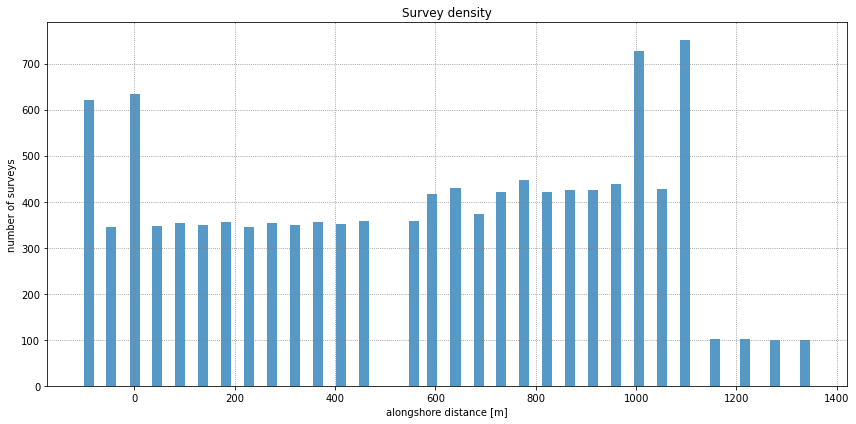

In [28]:
# plot survey density
fig, ax = plt.subplots(1,1,figsize=(12,6), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.bar(x=profiles,height=n_surveys,width=20,fc='C0',ec='None',alpha=0.75)
ax.set(xlabel='alongshore distance [m]',ylabel='number of surveys',title='Survey density');
fig.savefig(os.path.join(data_folder, '%s_survey_density.jpg'%sitename), dpi=100);

Plot selected transects

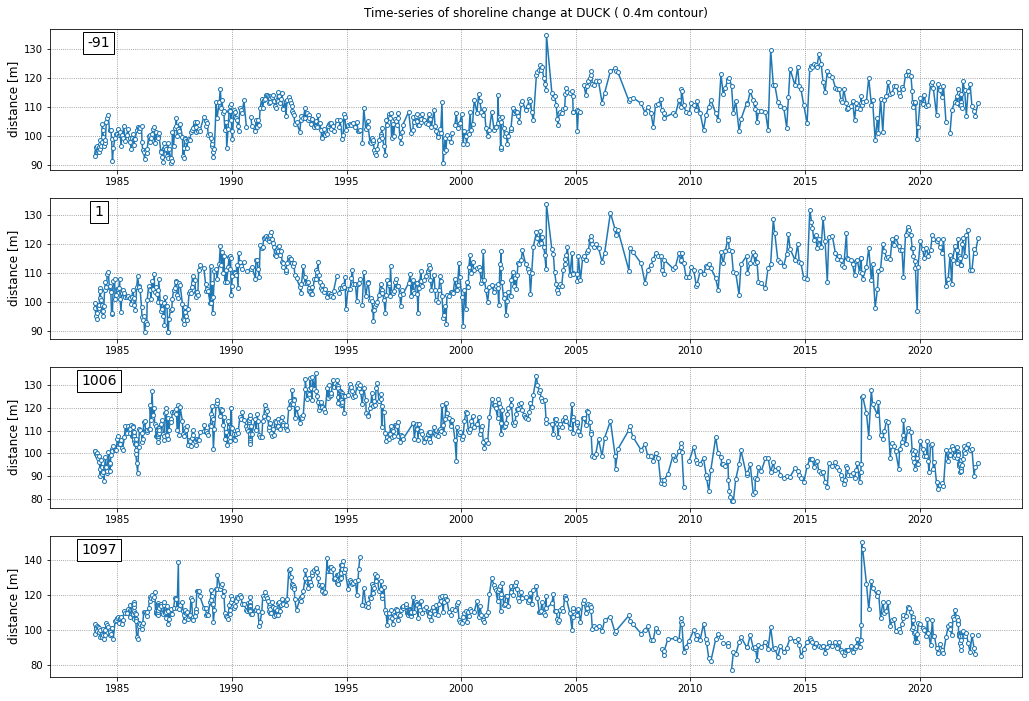

In [33]:
# plot time-series for selected transects
selected_transects = ['-91','1','1006','1097']
fig = plt.figure(figsize=[15,10], tight_layout=True)
fig.suptitle('Time-series of shoreline change at %s ( %.1fm contour)'%(sitename,contour_level))
gs = gridspec.GridSpec(len(selected_transects),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.2)
for i,key in enumerate(selected_transects):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.05,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14) 
fig.savefig(os.path.join(data_folder, '%s_insitu_timeseries.jpg'%sitename), dpi=100);

Now that we have preprocessed the in situ shoreline time-series, `.\datasets\DUCK\DUCK_groundtruth.pkl`, we can use them to evaluate the accuracy of satellite-derived shorelines.

The inputs for this site are provided under `./datasets/DUCK/`:
- Region of Interest (ROI): `DUCK_polygon.geojson` in WGS84 (epsg:4326)
- Reference shoreline: `DUCK_reference_shoreline.geojson` in WGS84 (epsg:4326)
- Transect coordinates: `DUCK_transects.geojson`  in WGS84 (epsg:4326)
- Modelled tide levels: `DUCK_tides.csv` dates in UTC time and tide levels in metres Above Mean Sea Level
- Beach-face slope: use $tan\beta = 0.1$

The cell below shows how to load the input files:

Loaded polygon in epsg:4326
Loaded reference shoreline in epsg:4326
Loaded transects in epsg:4326
Plotted polygon, reference shoreline and transects
Loaded tide time-series
Plotted tide time-series


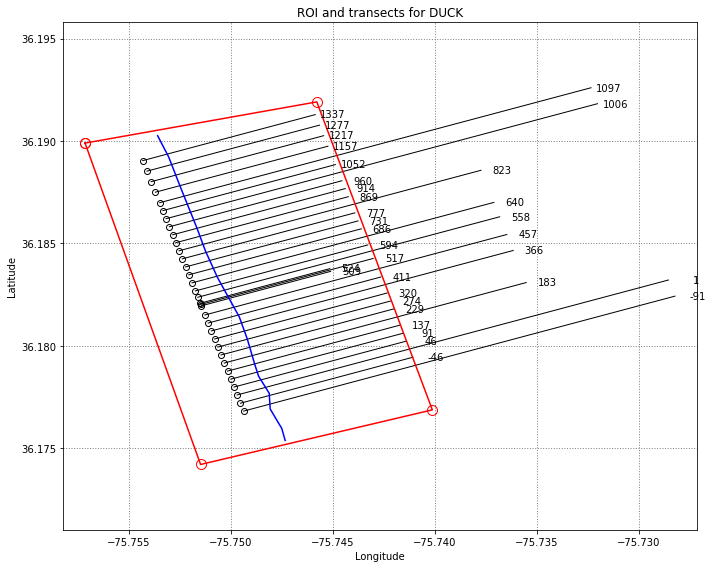

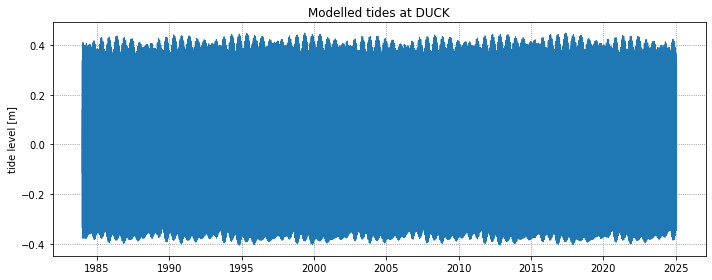

In [34]:
# read polygon ROI
fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
gdf_polygon = gpd.read_file(fn_polygon)
print('Loaded polygon in epsg:%d'%gdf_polygon.crs.to_epsg())
polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
# read reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
# read transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot transects and polygon
fig,ax = plt.subplots(1,1,figsize=(10,8),tight_layout=True)
ax.grid(which='major',ls=':',c='0.5',lw=1)
ax.axis('equal')
ax.set(xlabel='Longitude',ylabel='Latitude',title='ROI and transects for %s'%sitename)
for i,key in enumerate(list(transects.keys())):
    ax.plot(transects[key][0,0],transects[key][0,1], 'ko',mfc='None',ms=6)
    ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    ax.text(transects[key][-1,0]+0.0015, transects[key][-1,1], key,
            va='center', ha='right',)
ax.plot(polygon[:,0],polygon[:,1],'r-o',mfc='None',ms=10)
ax.plot(refsl[:,0],refsl[:,1],'b-')
print('Plotted polygon, reference shoreline and transects')
fig.savefig(os.path.join(data_folder, '%s_inputs.jpg'%sitename), dpi=100);

# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])
print('Loaded tide time-series')

# plot tide time-series
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-',lw=1)
ax.set(ylabel='tide level [m]',title='Modelled tides at %s'%sitename)
print('Plotted tide time-series')
fig.savefig(os.path.join(data_folder, '%s_tides.jpg'%sitename), dpi=100);

## 3. Truc Vert, France, METHYS dataset

The Truc Vert dataset is publicly available in this data repository https://osf.io/jftw8/, and described in this [Scientific Data paper](https://www.nature.com/articles/s41597-020-00750-5).

The data is organised in .nc files, one file per survey date. Download the repository and unzip it in `./datasets/TRUCVERT/raw`.

The code below shows how to process the dataset into time-series of shoreline change along transects.

![image.png](./doc/download_trucvert.png)

In [65]:
# folder to save the files in
sitename = 'TRUCVERT'
data_folder = os.path.join('datasets',sitename)
fp_raw = os.path.join(data_folder,'raw')

We use the data that was already interpolated on a 2m cross-shore, 20m alongshore grid. 

Processed 294 surveys


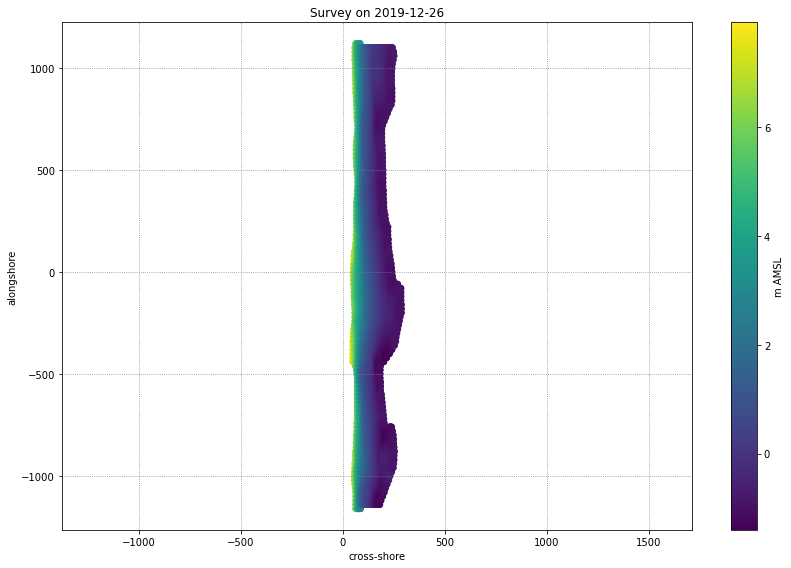

In [66]:
# read DEMs (already interpolated on a grid)
fp_figs = os.path.join(data_folder,'figs_dem')
if not os.path.exists(fp_figs): os.makedirs(fp_figs)
survey_data = dict([])
filenames = os.listdir(fp_raw)
filenames = [_ for _ in filenames if 'Monitoring' in _]
# load Grid.nc file which contains the coordinates of the interpolation grid
grid = Dataset(os.path.join(fp_raw,'Grids.nc'))
grid_data = dict([])
grid_data['lat'] = np.array(grid.variables['latg'][:])
grid_data['lon'] = np.array(grid.variables['long'][:])
grid_data['x'] = np.array(grid.variables['xlg'][:])
grid_data['y'] = np.array(grid.variables['ylg'][:])
# read the .nc files and store the date and elevation for each file
for i,fn in enumerate(filenames):
    data = Dataset(os.path.join(fp_raw,fn))
    date_str = fn[-13:].split('.nc')[0]
    date = pytz.utc.localize(datetime.strptime(date_str,'%Y-%m-%d'))
    survey_data[date_str] = dict([])
    survey_data[date_str]['date'] = date
    elevation = np.array(data.variables['zg'][:])
    elevation[elevation < -100] = np.nan
    survey_data[date_str]['elevation'] = elevation

    # plot the last DEM for illustration
    if i == len(filenames) - 1:
        fig, ax = plt.subplots(1,1,figsize=(12,8),tight_layout=True)
        ax.grid(which='major',ls=':',c='0.5')
        ax.axis('equal')
        sc = ax.scatter(grid_data['x'],grid_data['y'],c=survey_data[date_str]['elevation'])
        ax.set(title='Survey on %s'%date_str,xlabel='cross-shore',ylabel='alongshore')
        plt.colorbar(sc,label='m AMSL')
#         plt.savefig(os.path.join(fp_figs,'survey_%s.jpg'%date_str))
#         plt.close(plt.gcf())

print('Processed %d surveys'%len(filenames))

Now we extract time-series of shoreline change along each cross-shore transect (i.e., every 20 m alongshore).

Extracting time-series for 176 transects using the 1.5 m contour...
Time-series for the 1.5 m contour along 176 transects were saved at datasets\TRUCVERT\TRUCVERT_groundtruth.pkl


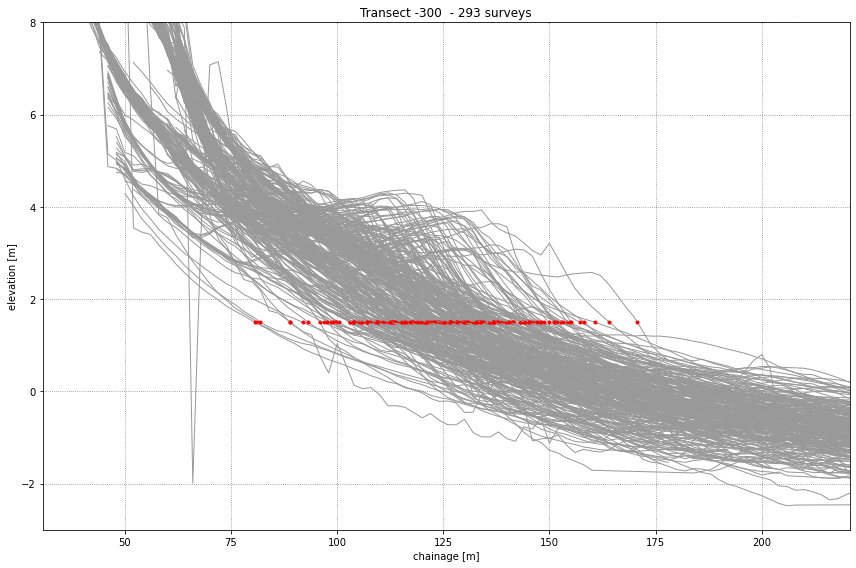

In [67]:
fp_figs = os.path.join(data_folder,'figs_topo')
if not os.path.exists(fp_figs): os.makedirs(fp_figs)
topo_profiles = dict([])
pf_names = [str(int(grid_data['y'][0,i])) for i in range(len(grid_data['y']))]
n_surveys = np.zeros(len(pf_names))

# select contour level to extract the shoreline time-series
contour_level = 1.5 # the elevations are already in MSL datum

print('Extracting time-series for %d transects using the %.1f m contour...'%(len(pf_names),contour_level))

# select transect to plot for illustration
transects_to_plot = ['-300']
# uncomment to plot all transects
# transects_to_plot = pf_names
for i in range(len(pf_names)):
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    # plot one of the profiles for illustration
    if pf_names[i] in transects_to_plot:
        fig, ax = plt.subplots(1,1,figsize=(12,8),tight_layout=True)
        ax.grid(which='major', linestyle=':', color='0.5')
    # loop through each survey and extract the contour
    for n in list(survey_data.keys()):
        survey = survey_data[n]
        date = survey_data[n]['date']
        chainages = grid_data['x'][:,i]
        elevations = survey['elevation'][:,i]
        # remove nans
        idx_nan = np.isnan(elevations)
        # if less than 5 survey points along the transect, skip it
        if len(elevations) - sum(idx_nan) <= 5: continue
        chainages = chainages[~idx_nan]
        elevations = elevations[~idx_nan]
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations, chainages, bounds_error=False)
        chainage_contour_level = float(f(contour_level))            
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        topo_profiles[pf_names[i]]['dates'].append(date)  
        if pf_names[i] in transects_to_plot:
            ax.plot(chainages,elevations,'-',c='0.6',lw=1)
            ax.plot(chainage_contour_level,contour_level,'r.')
    # convert to np.array
    topo_profiles[pf_names[i]]['chainages'] = np.array(topo_profiles[pf_names[i]]['chainages'])
    n_surveys[i] = len(topo_profiles[pf_names[i]]['dates'])
    if len(topo_profiles[pf_names[i]]['dates']) == 0:
        topo_profiles.pop(pf_names[i])
        continue
    if pf_names[i] in transects_to_plot:
        ax.set(title = 'Transect %s  - %d surveys'%(pf_names[i],len(topo_profiles[pf_names[i]]['dates'])),
               xlabel='chainage [m]', ylabel='elevation [m]', ylim=[-3,8],
               xlim=[np.nanmin(topo_profiles[pf_names[i]]['chainages'])-50,
                     np.nanmax(topo_profiles[pf_names[i]]['chainages'])+50])    
#         fig.savefig(os.path.join(fp_figs, 'transect_%s.jpg'%pf_names[i]), dpi=100)
#         plt.close(fig)

# save time-series in a pickle file
fp_save = os.path.join(data_folder, '%s_groundtruth.pkl'%sitename)
with open(fp_save, 'wb') as f:
    pickle.dump(topo_profiles, f)
print('Time-series for the %.1f m contour along %d transects were saved at %s'%(contour_level,len(pf_names),fp_save))

Now we have time-series of shoreline change for the 1m contour along 176 transects that are 20m spaced. 

However, not all transects have the same number of datapoints, as the surveys do not always cover the entire domain. We can plot the number of surveys per transect and select one in a high-density area to evaluate the accuracy of satellite-derived shorelines.

Based on the plot below, we can select transects around `-300m` alongshore for example, which is the region with most datapoints.

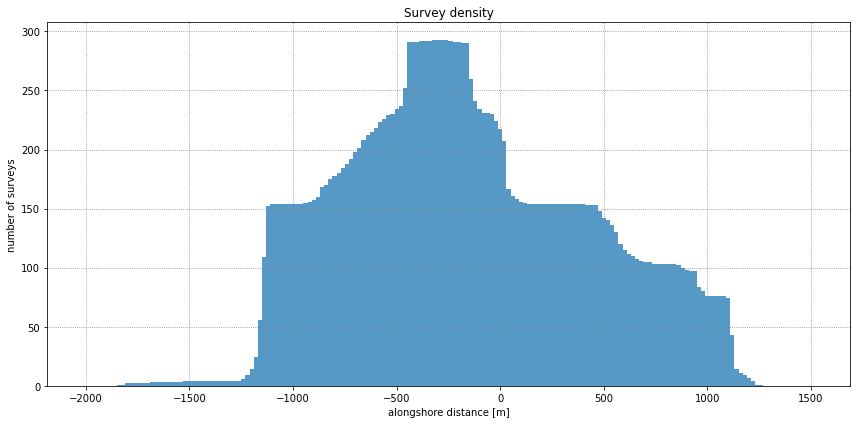

In [68]:
# plot survey density
fig, ax = plt.subplots(1,1,figsize=(12,6), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.bar(x=grid_data['y'][0,:],height=n_surveys,width=20,fc='C0',ec='None',alpha=0.75)
ax.set(xlabel='alongshore distance [m]',ylabel='number of surveys',title='Survey density');
fig.savefig(os.path.join(data_folder, '%s_survey_density.jpg'%sitename), dpi=100);

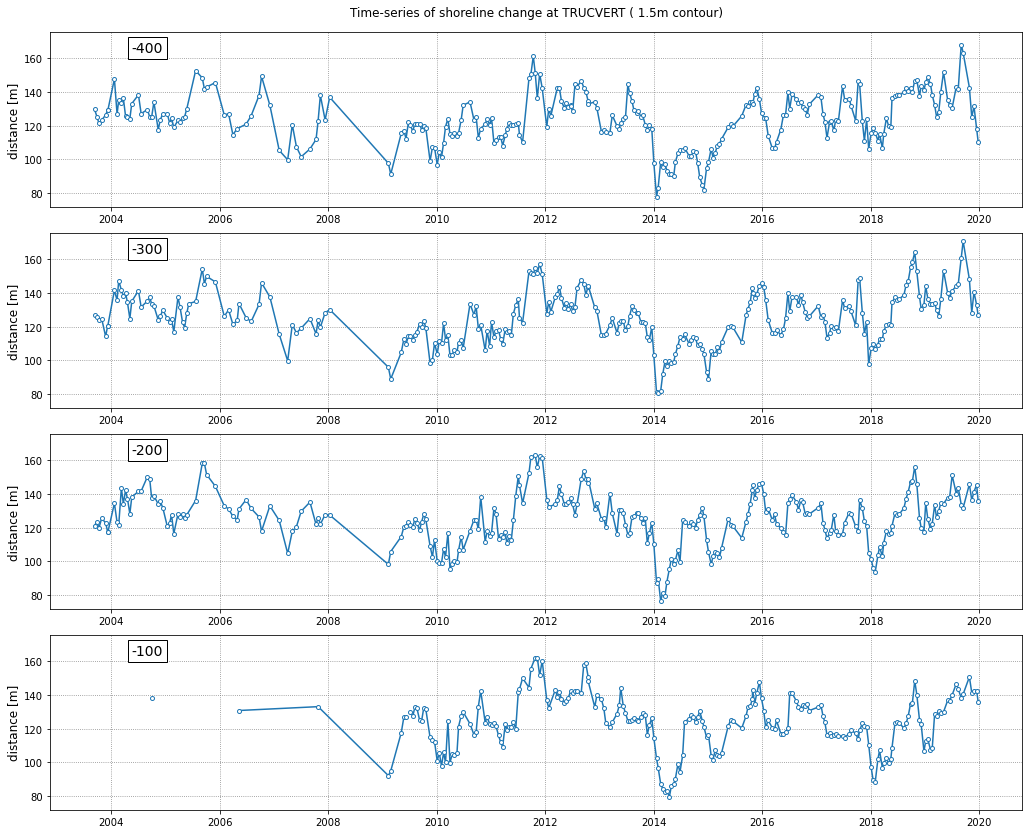

In [71]:
# plot time-series along specific transect
selected_transects = [-400,-300,-200,-100]
selected_transects = ['%d'%_ for _ in selected_transects]
fig = plt.figure(figsize=[15,12], tight_layout=True)
fig.suptitle('Time-series of shoreline change at %s ( %.1fm contour)'%(sitename,contour_level))
gs = gridspec.GridSpec(len(selected_transects),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.15)
for i,key in enumerate(selected_transects):
    if i > 0: ax = fig.add_subplot(gs[i,0],sharex=ax,sharey=ax)
    else:     ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.1,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14) 
fig.savefig(os.path.join(data_folder, '%s_insitu_timeseries.jpg'%sitename), dpi=100);

Now that we have preprocessed the in situ shoreline time-series, `.\datasets\TRUCVERT\TRUCVERT.pkl`, we can use them to evaluate the accuracy of satellite-derived shorelines.

The inputs for this site are provided under `./datasets/TRUCVERT/`:
- Region of Interest (ROI): `TRUCVERT_polygon.geojson` in WGS84 (epsg:4326)
- Reference shoreline:  `TRUCVERT_reference_shoreline.geojson` in WGS84 (epsg:4326)
- Transect coordinates: `TRUCVERT_transects.geojson`  in WGS84 (epsg:4326)
- Modelled tide levels: `TRUCVERT_tides.csv` dates in UTC time and tide levels in metres Above Mean Sea Level
- Beach-face slope: use $tan\beta = 0.05$


The cell below shows how to load the input files:

Loaded polygon in epsg:4326
Loaded reference shoreline in epsg:4326
Loaded transects in epsg:4326
Plotted polygon, reference shoreline and transects
Loaded tide time-series
Plotted tide time-series


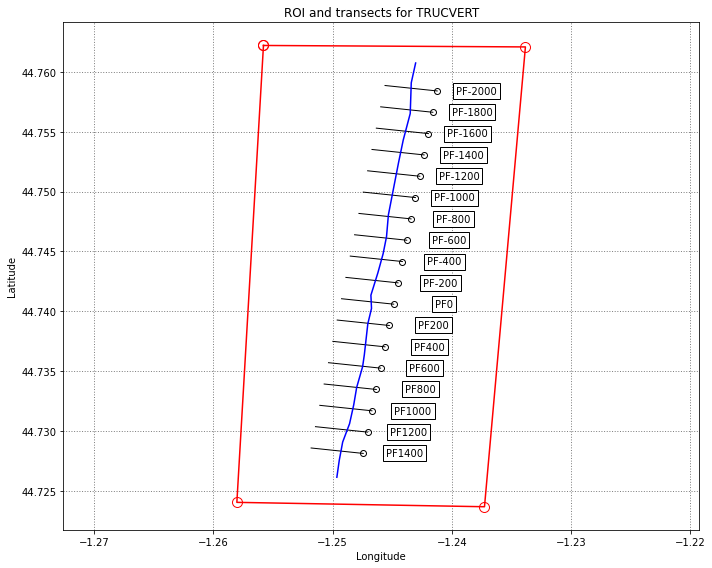

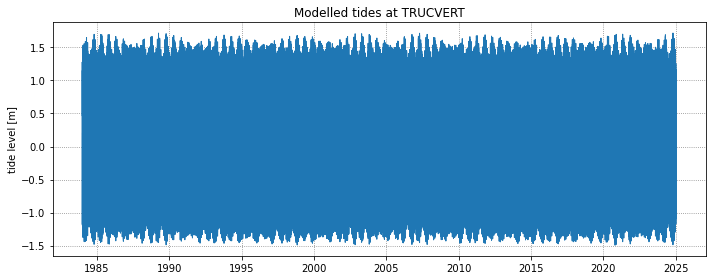

In [43]:
# read polygon ROI
fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
gdf_polygon = gpd.read_file(fn_polygon)
print('Loaded polygon in epsg:%d'%gdf_polygon.crs.to_epsg())
polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
# read reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
# read transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot transects and polygon
fig,ax = plt.subplots(1,1,figsize=(10,8),tight_layout=True)
ax.grid(which='major',ls=':',c='0.5',lw=1)
ax.axis('equal')
ax.set(xlabel='Longitude',ylabel='Latitude',title='ROI and transects for %s'%sitename)
for i,key in enumerate(list(transects.keys())):
    if i % 10 == 0 : # plot one every 10 transects (200 m)
        ax.plot(transects[key][0,0],transects[key][0,1], 'ko',mfc='None',ms=6)
        ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
        ax.text(transects[key][0,0]+0.005, transects[key][0,1], key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
ax.plot(polygon[:,0],polygon[:,1],'r-o',mfc='None',ms=10)
ax.plot(refsl[:,0],refsl[:,1],'b-')
print('Plotted polygon, reference shoreline and transects')
fig.savefig(os.path.join(data_folder, '%s_inputs.jpg'%sitename), dpi=100);

# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])
print('Loaded tide time-series')

# plot tide time-series
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-',lw=1)
ax.set(ylabel='tide level [m]',title='Modelled tides at %s'%sitename)
print('Plotted tide time-series')
fig.savefig(os.path.join(data_folder, '%s_tides.jpg'%sitename), dpi=100);

## 4. San Diego beaches, Scripps dataset (in progress)

The San Diego shoreline dataset is publicly available in this data repository https://datadryad.org/stash/dataset/doi:10.5061/dryad.n5qb383, and described in this [Scientific Data paper](https://www.nature.com/articles/s41597-019-0167-6).

Download the data from the DRYAD repository and unzip it.

![image.png](./doc/download_sandiego.PNG)

The dataset contains topographic surveys for 4 different beaches in the San Diego area:
- `Torrey Pines beach`
- `Solana beach`
- `Imperial beach`
- `Cardiff State beach`

The data for each beach is contained in a separate zip file. 

Let's first focus on Torrey Pines, the same workflow can be applied to the other beaches. Amongst the different products provided, we use the `mapped_sand_elevations` which were interpolated and smoothed over a uniform grid.

Select `torrey_mapped_sand_elevations.zip` and unzip it under `./datasets/TORREYPINES/raw`

![image.png](./doc/download_sandiego2.PNG)


In [44]:
sitename = 'TORREYPINES'
data_folder = os.path.join('datasets',sitename)
fp_raw = os.path.join(data_folder,'raw')

We use the data that was already interpolated along a set of fixed cross-shore transects at a 2m cross-shore resolution.

Processed 255 surveys


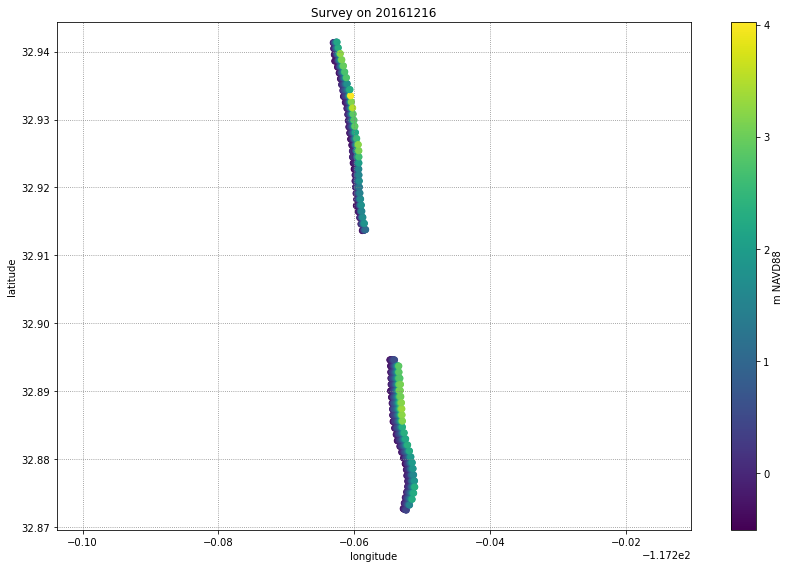

In [45]:
# read DEMs (already interpolated on a grid)
fp_files = os.path.join(fp_raw,'torrey_mapped_sand_elevations','torrey_mapped_sand_elevations') # check that path is correct
fp_figs = os.path.join(data_folder,'figs_dem')
if not os.path.exists(fp_figs): os.makedirs(fp_figs)
survey_data = dict([])
filenames = os.listdir(fp_files)
filenames = [_ for _ in filenames if '.nc' in _]
# read the .nc files and store the date and elevation for each file
for i,fn in enumerate(filenames):
    data = Dataset(os.path.join(fp_files,fn))
    date_str = fn.split('_')[0].split('map')[1]
    date = pytz.utc.localize(datetime.strptime(date_str,'%Y%m%d'))
    survey_data[date_str] = dict([])
    survey_data[date_str]['date'] = date
    elevation = np.array(data.variables['mapz'][:])
    elevation[elevation < -100] = np.nan
    # store in dictionary
    survey_data[date_str]['elevation'] = elevation
    survey_data[date_str]['x'] = np.array(data.variables['xc'][:])
    survey_data[date_str]['y'] = np.array(data.variables['yc'][:])
    survey_data[date_str]['pf'] = np.array(data.variables['alg'][:])
    survey_data[date_str]['lat'] = np.array(data.variables['latc'][:])
    survey_data[date_str]['lon'] = np.array(data.variables['lonc'][:])    

    # plot the last DEM for illustration
    if i == len(filenames) - 1:
        fig, ax = plt.subplots(1,1,figsize=(12,8),tight_layout=True)
        ax.grid(which='major',ls=':',c='0.5')
        ax.axis('equal')
        sc = ax.scatter(survey_data[date_str]['lon'],survey_data[date_str]['lat'],c=survey_data[date_str]['elevation'])
        ax.set(title='Survey on %s'%date_str,xlabel='longitude',ylabel='latitude')
        plt.colorbar(sc,label='m NAVD88')
        # plt.savefig(os.path.join(fp_figs,'survey_%s.jpg'%date_str))
        # plt.close(plt.gcf())

print('Processed %d surveys'%len(filenames))

Now we extract time-series of shoreline change along each cross-shore transect.

Note that the elevations are in NAVD88 datum, which is about 0.8 m higher than MSL at this location (https://tidesandcurrents.noaa.gov/datums.html?datum=NAVD88&units=1&epoch=0&id=9410230&name=La+Jolla&state=CA). Based on this tidal datum, the MHHW level is 1.6 m.

Extracting time-series for 79 transects using the 1.6 m contour...
Time-series for the 2 m contour along 79 transects were saved at datasets\TORREYPINES\TORREYPINES_groundtruth.pkl


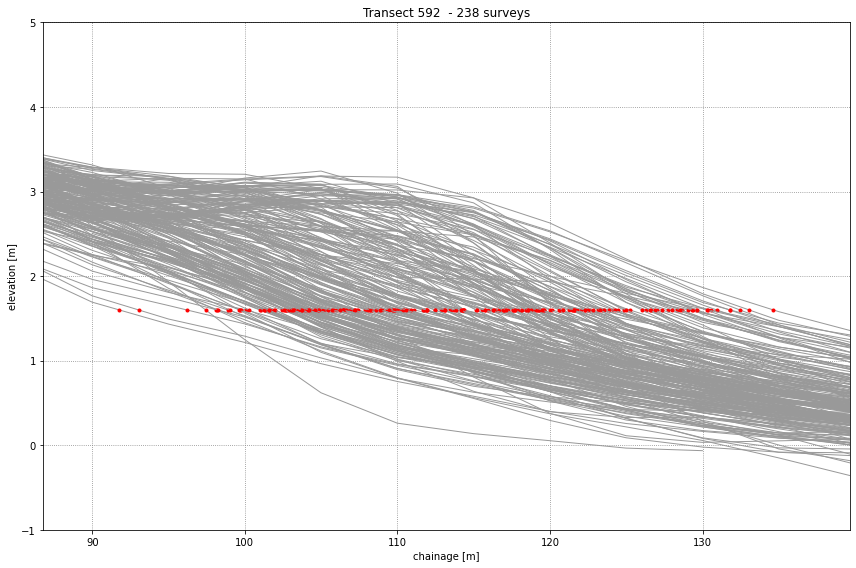

In [46]:
# format the data by profile and not by date
fp_figs = os.path.join(data_folder,'figs_topo')
if not os.path.exists(fp_figs): os.makedirs(fp_figs)
topo_profiles = dict([])
pf_names = [str(int(survey_data[date_str]['pf'][0,i])) for i in range(survey_data[date_str]['pf'].shape[1])]
n_surveys = np.zeros(len(pf_names))

# select contour level to extract the shoreline time-series
contour_level = 1.6 # in NAVD88 according to https://tidesandcurrents.noaa.gov/datums.html?datum=NAVD88&units=1&epoch=0&id=9410230&name=La+Jolla&state=CA

print('Extracting time-series for %d transects using the %.1f m contour...'%(len(pf_names),contour_level))

# select transect to plot for illustration
transects_to_plot = ['592']
# uncomment to plot all transects
# transects_to_plot = pf_names
for i in range(len(pf_names)):
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    # plot one of the profiles for illustration
    if pf_names[i] in transects_to_plot:
        fig, ax = plt.subplots(1,1,figsize=(12,8),tight_layout=True)
        ax.grid(which='major', linestyle=':', color='0.5')
    # loop through each survey and extract the contour
    for n in list(survey_data.keys()):
        survey = survey_data[n]
        date = survey_data[n]['date']
        elevations = survey['elevation'][:,i]
        # remove nans
        idx_nan = np.isnan(elevations)
        # if less than 5 survey points along the transect, skip it
        if len(elevations) - sum(idx_nan) <= 5: continue
        # create transect with its eastings northings coordinates
        transect = np.zeros([survey['x'].shape[0],2])
        transect[:,0] = survey['x'][:,i]
        transect[:,1] = survey['y'][:,i]
        # flip it so that origin is on land pointing seawards
        transect = np.flipud(transect)
        # calculate chainage
        x = np.sqrt((transect[:,0]-transect[0,0])**2 + (transect[:,1]-transect[0,1])**2)
        # also flip elevations to match chainages
        z = np.flipud(elevations) 
        # remove nans
        idx_nan = np.isnan(z)
        x = x[~idx_nan]
        z = z[~idx_nan]
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(z, x, bounds_error=False)
        chainage_contour_level = float(f(contour_level))            
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        topo_profiles[pf_names[i]]['dates'].append(date)  
        if pf_names[i] in transects_to_plot:
            ax.plot(x,z,'-',c='0.6',lw=1)
            ax.plot(chainage_contour_level,contour_level,'r.')
    # convert to np.array
    topo_profiles[pf_names[i]]['chainages'] = np.array(topo_profiles[pf_names[i]]['chainages'])
    n_surveys[i] = len(topo_profiles[pf_names[i]]['dates'])
    if len(topo_profiles[pf_names[i]]['dates']) == 0:
        topo_profiles.pop(pf_names[i])
        continue
    if pf_names[i] in transects_to_plot:
        ax.set(title = 'Transect %s  - %d surveys'%(pf_names[i],len(topo_profiles[pf_names[i]]['dates'])),
               xlabel='chainage [m]', ylabel='elevation [m]', ylim=[-1,5],
               xlim=[np.nanmin(topo_profiles[pf_names[i]]['chainages'])-5,
                     np.nanmax(topo_profiles[pf_names[i]]['chainages'])+5])    
        # fig.savefig(os.path.join(fp_figs, 'transect_%s.jpg'%pf_names[i]), dpi=100)
        # plt.close(plt.gcf())
        
# save time-series in a pickle file
fp_save = os.path.join(data_folder, '%s_groundtruth.pkl'%sitename)
with open(fp_save, 'wb') as f:
    pickle.dump(topo_profiles, f)
print('Time-series for the %1.f m contour along %d transects were saved at %s'%(contour_level,len(pf_names),fp_save))


Now we have time-series of shoreline change for all the transects.
As for Truc Vert and Duck, not all the transects contain the same number of surveys. So we can plot the survey density for each transect.

Based on the plot below, we can select transects between 520 and 540, and transects betwenn 570 and 590 as these contain more than 200 datapoints.

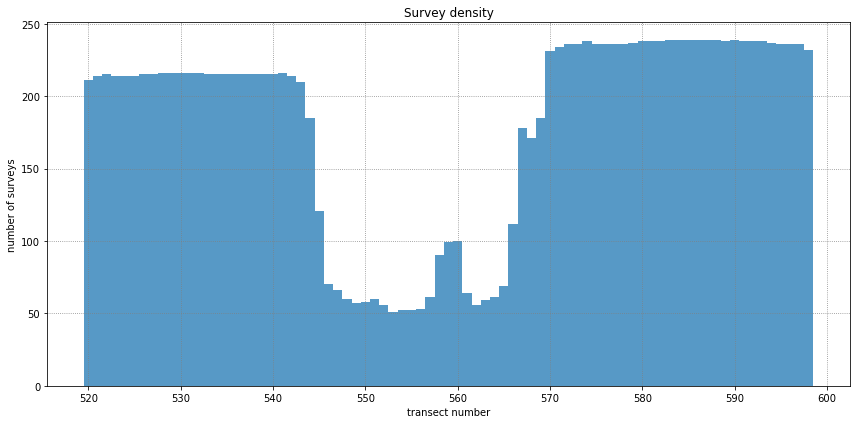

In [47]:
# plot survey density
fig, ax = plt.subplots(1,1,figsize=(12,6), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.bar(x=survey_data[date_str]['pf'][0,:],height=n_surveys,width=1,fc='C0',ec='None',alpha=0.75)
ax.set(xlabel='transect number',ylabel='number of surveys',title='Survey density');
fig.savefig(os.path.join(data_folder, '%s_survey_density.jpg'%sitename), dpi=100);

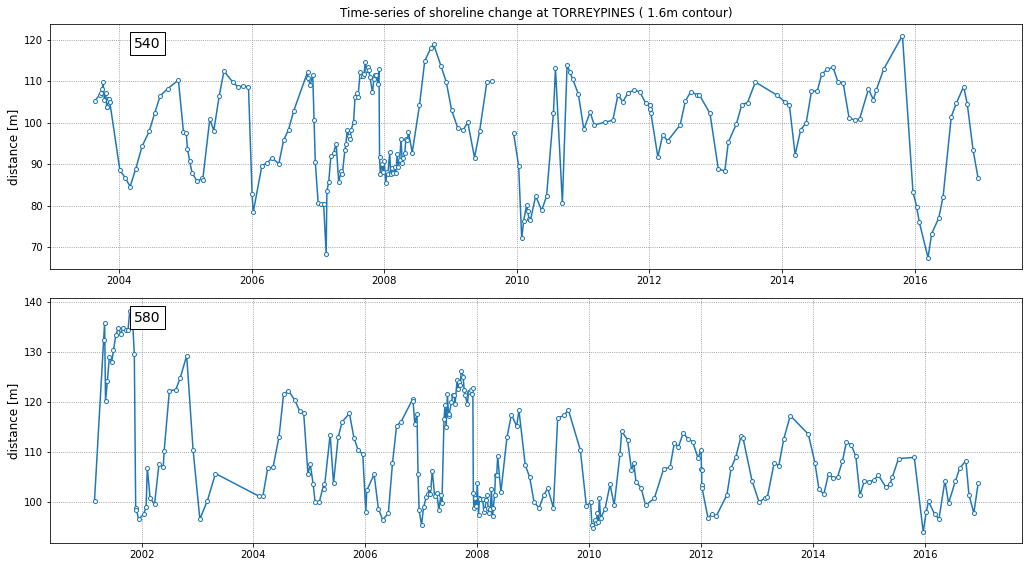

In [48]:
# plot time-series along specific transect
selected_transects = ['540','580']
fig = plt.figure(figsize=[15,8], tight_layout=True)
fig.suptitle('Time-series of shoreline change at %s ( %.1fm contour)'%(sitename,contour_level))
gs = gridspec.GridSpec(len(selected_transects),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.12)
for i,key in enumerate(selected_transects):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.1,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  
fig.savefig(os.path.join(data_folder, '%s_insitu_timeseries.jpg'%sitename), dpi=100);

Now that we have preprocessed the in situ shoreline time-series, `.\datasets\TORREYPINES\TORREYPINES.pkl`, we can use them to evaluate the accuracy of satellite-derived shorelines.

The inputs for this site are provided under `./datasets/TORREYPINES/`:
- Region of Interest (ROI): `TORREYPINES_polygon.geojson` in WGS84 (epsg:4326)
- Reference shoreline: `TORREYPINES_reference_shoreline.geojson` in WGS84 (epsg:4326)
- Transect coordinates: `TORREYPINES_transects.geojson`  in WGS84 (epsg:4326)
- Modelled tide levels: `TORREYPINES_tides.csv` dates in UTC time and tide levels in metres Above Mean Sea Level
- Beach-face slope: use $tan\beta = 0.035$


The cell below shows how to load the input files:

Loaded polygon in epsg:4326
Loaded reference shoreline in epsg:4326
Loaded transects in epsg:4326
Plotted polygon, reference shoreline and transects
Loaded tide time-series
Plotted tide time-series


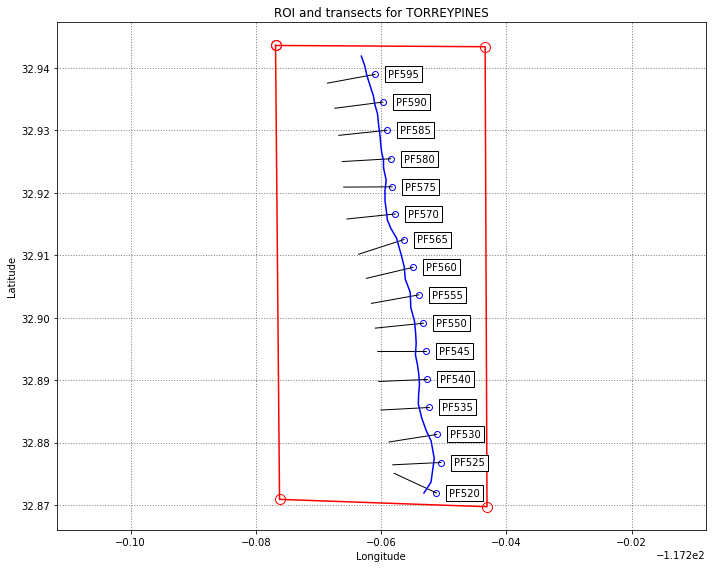

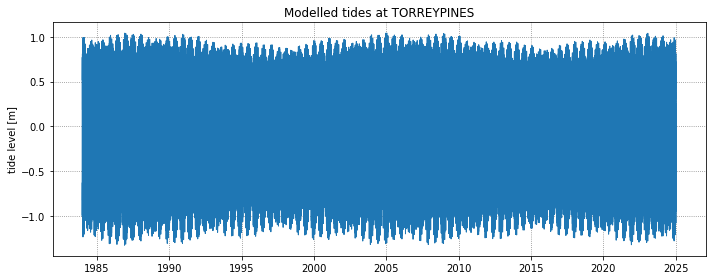

In [49]:
# read polygon ROI
fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
gdf_polygon = gpd.read_file(fn_polygon)
print('Loaded polygon in epsg:%d'%gdf_polygon.crs.to_epsg())
polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
# read reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
# read transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot transects and polygon
fig,ax = plt.subplots(1,1,figsize=(10,8),tight_layout=True)
ax.grid(which='major',ls=':',c='0.5',lw=1)
ax.axis('equal')
ax.set(xlabel='Longitude',ylabel='Latitude',title='ROI and transects for %s'%sitename)
for i,key in enumerate(list(transects.keys())):
    if i % 5 == 0 : # plot one every 5 transects
        ax.plot(transects[key][0,0],transects[key][0,1], 'bo',mfc='None',ms=6)
        ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
        ax.text(transects[key][0,0]+0.007, transects[key][0,1], key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
ax.plot(polygon[:,0],polygon[:,1],'r-o',mfc='None',ms=10)
ax.plot(refsl[:,0],refsl[:,1],'b-')
print('Plotted polygon, reference shoreline and transects')
fig.savefig(os.path.join(data_folder, '%s_inputs.jpg'%sitename), dpi=100);

# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])
print('Loaded tide time-series')

# plot tide time-series
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-',lw=1)
ax.set(ylabel='tide level [m]',title='Modelled tides at %s'%sitename)
print('Plotted tide time-series')
fig.savefig(os.path.join(data_folder, '%s_tides.jpg'%sitename), dpi=100);